In [1]:
#pip install keras
#pip install -U scikit-learn
#pip install pillow
#pip install matplotlib
#pip install jupyternotify
#unzip DR\ no\ aug
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

2023-04-01 17:34:44.814589: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Variables Being Used

In [3]:
#variables being used
batch_size=32
#val_split=0.2 #20 percent validation
image_size=512 
image_shape=(image_size,image_size)
#file_directory='/root/DR no aug'
#file_directory='/root/01DR_noDR'
train_file_directory='/root/DR-detection-using-OCT-A/train_val_split/Training'
validation_file_directory='/root/DR-detection-using-OCT-A/train_val_split/Validation'
alt_train_file_directory='/root/DR-detection-using-OCT-A/train_val_split/Training_no_weights'

In [13]:
!nvidia-smi

Sat Apr  1 17:47:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.78.01    Driver Version: 525.78.01    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:03:00.0 Off |                  N/A |
| 30%   53C    P2   114W / 350W |  23376MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing Datasets

In [4]:

from keras.applications.xception import preprocess_input #for that vgg16
#import tensorflow as tf

#from keras.applications.Xception import preprocess_input

training_datagen = ImageDataGenerator( 
        preprocessing_function=preprocess_input, # use this only when using VGG16
        #rescale=1./255,
        rotation_range=40,#can change this
        shear_range=0.2,#can change this
        zoom_range=0.2, #can change this
        horizontal_flip=True,
        fill_mode='reflect',# constant,reflect,wrap,
        )

validation_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #rescale=1./255    
        )

#Creating our generators, no need of changing values here
train_generator = training_datagen.flow_from_directory( #Creating our training generator 
        train_file_directory,  
        target_size=image_shape,
        batch_size=batch_size,
        #color_mode='grayscale',
        class_mode='categorical',
        shuffle = False,
        )

validation_generator = validation_datagen.flow_from_directory( #Creating our validation generator
        validation_file_directory, 
        target_size=image_shape, 
        batch_size=batch_size,
        #color_mode='grayscale',
        class_mode='categorical',
        shuffle = False,
)

Found 561 images belonging to 3 classes.
Found 50 images belonging to 3 classes.


## Displaying Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


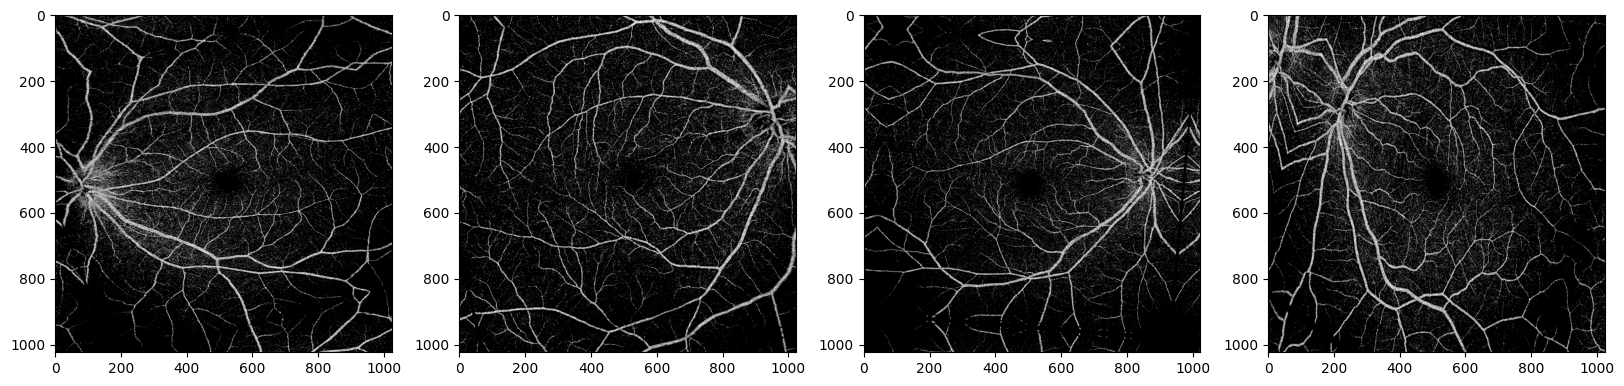

In [5]:
# Enable/Disable to see 4 random images
fig, axs=plt.subplots(ncols=4, figsize=(20,20))
for i in range(4):
  axs[i].imshow(train_generator[i][0][0], cmap='gray', vmin=0, vmax=1)
#axs[0].plt.show()

## Creating weights

In [6]:
import numpy as np ## Calculating the class weights
from sklearn.utils.class_weight import compute_class_weight

class_weighing = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights=dict(zip(np.unique(train_generator.classes), class_weighing))

print(class_weights)

{0: 0.6051779935275081, 1: 0.9739583333333334, 2: 3.1166666666666667}


## Creating Model

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D
from keras.optimizers import SGD
import keras

In [8]:
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(image_size, image_size, 3),
    include_top=False)

base_model.trainable = False
inputs = keras.Input(shape=(image_size, image_size, 3))

x = base_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.15)(x)  # Regularize with dropout
x=keras.layers.Dense(1000)(x)
x=keras.layers.Dense(1000)(x)
outputs = keras.layers.Dense(3)(x)
model = keras.Model(inputs, outputs)


model.summary(expand_nested=False)

2023-04-01 17:35:17.407551: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22229 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:03:00.0, compute capability: 8.6


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024, 1024, 3)]   0         
                                                                 
 xception (Functional)       (None, 32, 32, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                                 
 dense_1 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_2 (Dense)             (None, 3)                 3003      
                                                             

### Compile

In [9]:
model.compile(optimizer=keras.optimizers.Adam(), #SGD or adam
              loss='categorical_crossentropy' ,
              metrics=['accuracy'])

### Generating Callbacks

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath="/root/saved_models/{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint= ModelCheckpoint(filepath,monitor='val_accuracy',verbose=0,save_best_only=True,mode='max')
early_stop=EarlyStopping(monitor='val_accuracy',patience=50,verbose=0) #only change patience

callback_list=[checkpoint,early_stop]#add the callbacks used

### Model.Fit()

In [12]:
%%notify
history=model.fit(
        train_generator,
        steps_per_epoch=len(train_generator.classes)//batch_size,
        verbose=1, 
        epochs=20,  #change this
        validation_data=validation_generator,
        validation_steps=len(validation_generator.classes)//batch_size,
        callbacks=callback_list,
        class_weight=class_weights)
print("Done bro")

Epoch 1/20


2023-04-01 17:36:44.691860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-01 17:36:56.003974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-01 17:36:58.220157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


17/17 [==============================] - ETA: 0s - loss: 7.8680 - accuracy: 0.3989

2023-04-01 17:38:47.924589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


17/17 [==============================] - 127s 7s/step - loss: 7.8680 - accuracy: 0.3989 - val_loss: 10.0738 - val_accuracy: 0.3750
Epoch 2/20
17/17 [==============================] - 120s 7s/step - loss: 5.3811 - accuracy: 0.2628 - val_loss: 10.2352 - val_accuracy: 0.0000e+00
Epoch 3/20
17/17 [==============================] - 120s 7s/step - loss: 5.1144 - accuracy: 0.1134 - val_loss: 10.0738 - val_accuracy: 0.0000e+00
Epoch 4/20
17/17 [==============================] - 120s 7s/step - loss: 5.1076 - accuracy: 0.1134 - val_loss: 10.0738 - val_accuracy: 0.0000e+00
Epoch 5/20
17/17 [==============================] - 120s 7s/step - loss: 5.1076 - accuracy: 0.1134 - val_loss: 10.0738 - val_accuracy: 0.0000e+00
Epoch 6/20


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

### Curves

In [ ]:
#loss curve
fig, axs=plt.subplots(ncols=2,figsize=(15, 5))#, figsize=(20,20))
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
axs[0].plot(epochs, loss, 'y', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set(title='Loss', xlabel='Epochs', ylabel='Epochs');

#accuracy curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
axs[1].plot(epochs, acc, 'y', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Epochs');

In [ ]:
"""prediction_classes = np.array([])
true_classes =  np.array([])
i=0
for x, y in validation_generator:
    if i==len(validation_generator.classes):
        break    
    i=i+1
    prediction_classes = np.concatenate([prediction_classes,np.argmax(model.predict(x,verbose=0), axis = -1)])
    true_classes = np.concatenate([true_classes, np.argmax(y, axis=-1)])
print(classification_report(true_classes, prediction_classes))"""

In [ ]:
#model.save('to_continue.h5')
#continue_model=load_model('to_continue.h5')

## Evaluating Model

In [ ]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

#model = load_model('/root/44-0.82.hdf5')

In [ ]:
#new_model=load_model(".hdf5")

In [ ]:
data_eval=validation_generator
model_eval=model
results=model_eval.evaluate_generator(data_eval, steps=len(data_eval.classes)//batch_size)
print("Loss and accuracy are", results)
Y_pred = model_eval.predict_generator(data_eval, steps=len(data_eval.classes)//batch_size+1)
#print(train_generator.classes)
y_pred = np.argmax(Y_pred, axis=1)
#print(train_generator.classes)
#print(y_pred)
#print(X)
        
print('Confusion Matrix')
cm=confusion_matrix(data_eval.classes,y_pred)
target_names = ['NoDR', 'mildDR','seriousDR']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('Classification Report')

print(classification_report(data_eval.classes,y_pred, target_names=target_names))